### Installing required libraries

In [ ]:
pip install neuralforecast==1.7.3 numpy==1.24.4  scikit-learn==1.3.2 matplotlib==3.7.1 pandas==2.1.4

Importing libraries

In [ ]:
import numpy as np
import pandas as pd
#import pytorch_lightning as pl
import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import MLP,NLinear
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss,MAE
from neuralforecast.tsdataset import TimeSeriesDataset
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from neuralforecast.utils import AirPassengers, AirPassengersPanel, AirPassengersStatic, augment_calendar_df

Create calculate error metrics function which helps in assessing the performance of the trained model

In [ ]:

def calculate_error_metrics(actual, predicted, num_predictors=1):
    # convert inputs are numpy arrays
    actual = np.array(actual)
    predicted = np.array(predicted)
    # Number of observations
    n = len(actual)
    # Calculate MSE
    mse = mean_squared_error(actual, predicted)
    # Calculate RMSE
    rmse = np.sqrt(mse)
    # Calculate MAPE
    mape = mean_absolute_percentage_error(actual, predicted)
    # Calculate R-squared
    r2 = r2_score(actual, predicted)
    # Calculate Adjusted R-squared
    adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - num_predictors - 1))
    print(f'MSE : {mse}')
    print(f'RMSE : {rmse}')
    print(f'MAPE : {mape}')
    print(f'r2 : {r2}')
    print(f'adjusted_r2 : {adjusted_r2}')

Load **AirPassenger** data set

In [ ]:
from neuralforecast.utils import AirPassengersDF
Y_df = AirPassengersDF
Y_df = Y_df.reset_index(drop=True)
Y_df.head()

# To load local csv  > modify to the right path where the file is present
#Y_df = pd.read_csv('AirPassengersDataset.csv')
#Y_df = Y_df.reset_index(drop=True)
#Y_df.head()

,unique_id,ds,y
0,1.0,1949-01-31,112.0
1,1.0,1949-02-28,118.0
2,1.0,1949-03-31,132.0
3,1.0,1949-04-30,129.0
4,1.0,1949-05-31,121.0


Split data into **train** and **test**

In [ ]:
Y_train_df = Y_df[Y_df.ds<='1959-12-31'] # 132 train
Y_test_df = Y_df[Y_df.ds>'1959-12-31']   # 12 test


Lets initialize and training model (**NLiner**) and define its hyperparameters.

In [ ]:
horizon =12
model = NLinear(h=horizon,
                 input_size=12,
                 loss=MAE(),
                 #loss=DistributionLoss(distribution='StudentT', level=[80, 90], return_params=True),
                 scaler_type='robust',
                 learning_rate=1e-3,
                 max_steps=500,
                 val_check_steps=50,
                 early_stop_patience_steps=2)

nf = NeuralForecast(
    models=[model],
    freq='M'
)

INFO:lightning_fabric.utilities.seed:Seed set to 1


In [ ]:
nf.fit(df=Y_train_df, val_size=12)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | linear       | Linear        | 156    | train
-------------------------------------------------------
156       Trainable params
0         Non-trainable params
156       Total params
0.001     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.


Predict for the next defined horizon

In [ ]:
forecasts = nf.predict()
forecasts.head()

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


,ds,NLinear
unique_id,,
1.0,1960-01-31,419.600891
1.0,1960-02-29,446.448914
1.0,1960-03-31,434.517181
1.0,1960-04-30,434.610718
1.0,1960-05-31,483.879761


Measure the models accuracy

In [ ]:
calculate_error_metrics(Y_test_df[['y']],forecasts['NLinear'])

MSE : 1214.2550048828125
RMSE : 34.846160888671875
MAPE : 0.06048479676246643
r2 : 0.7807995266526639
adjusted_r2 : 0.7588794793179303


Visualize the predictions

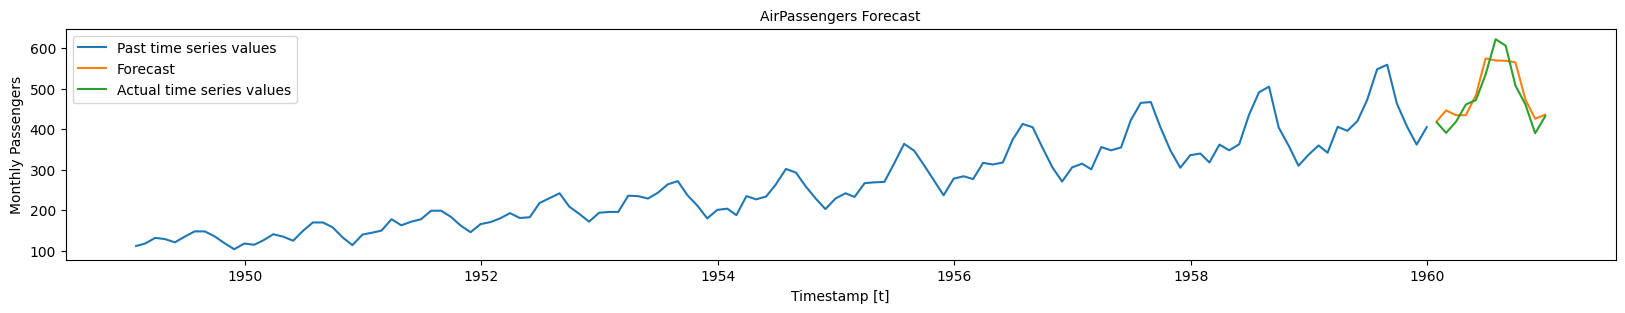

In [ ]:
Y_train_df.set_index('ds',inplace =True)
forecasts.set_index('ds',inplace =True)
Y_test_df.set_index('ds',inplace =True)

plt.figure(figsize=(20, 3))

y_past = Y_train_df["y"]
y_pred = forecasts['NLinear']
y_test = Y_test_df["y"]

plt.plot(y_past, label="Past time series values")
plt.plot(y_pred, label="Forecast")
plt.plot(y_test, label="Actual time series values")
plt.title('AirPassengers Forecast', fontsize=10)
plt.ylabel('Monthly Passengers', fontsize=10)
plt.xlabel('Timestamp [t]', fontsize=10)

plt.legend();